# Importando Bibliotecas e Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set()
sns.color_palette('hls', 8)

# Definindo fonte
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 30
        }

# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

# Carregando dados

In [2]:
fraud_df = pd.read_csv('Fraud.csv')
fraud_df_orig = fraud_df.copy()

fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [3]:
fraud_df.sample(15)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2097009,182,CASH_OUT,193403.20,C71631456,208555.00,15151.80,C1260921041,2660589.64,2853992.84,0,0
641661,35,CASH_IN,109119.38,C132071254,5008564.88,5117684.26,C804731631,947659.48,838540.10,0,0
575118,25,PAYMENT,14580.55,C567339448,17945.04,3364.50,M1217655881,0.00,0.00,0,0
1241076,134,PAYMENT,8099.02,C1112486850,0.00,0.00,M241621925,0.00,0.00,0,0
4617416,329,CASH_OUT,10266.53,C670099112,0.00,0.00,C2042983588,1490666.80,1500933.33,0,0
1674919,158,CASH_OUT,543430.23,C819512209,182138.94,0.00,C455343133,644540.12,1187970.34,0,0
4318197,308,PAYMENT,8640.09,C1220069031,0.00,0.00,M514442569,0.00,0.00,0,0
3966925,297,TRANSFER,1903602.00,C1285525241,140138.05,0.00,C1428384061,2163480.11,4067082.11,0,0
390440,17,PAYMENT,2911.69,C1869208923,177480.00,174568.31,M705709594,0.00,0.00,0,0
1536776,154,TRANSFER,2583598.20,C1042505145,11530.00,0.00,C1142390645,0.00,2583598.20,0,0


### Colunas:

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### Balanceando o Dataset (Undersampling)

In [4]:
frauds = fraud_df[fraud_df['isFraud'] == 1]
legits = fraud_df[fraud_df['isFraud'] == 0]

n_legits = len(legits)
n_frauds = len(frauds)

legits_percent = (n_legits / (n_frauds + n_legits)) * 100
frauds_percent = (n_frauds / (n_frauds + n_legits)) * 100

print("Número de transações legítimas: ", n_legits, '({:.4f}%)'.format(legits_percent))
print("Número de transações fraudulentas: ", n_frauds, '({:.4f}%)'.format(frauds_percent))

#Pegando 85% do total de transações fraudulentas para melhorar a performance do modelo de deploy
frauds = fraud_df[fraud_df['isFraud'] == 1].sample(frac = 0.85, random_state = 42)
n_frauds = len(frauds) #resetando valor de n_frauds para a mudança anterior

legits = legits.sample(n = n_frauds, random_state = 42)
df_reduced = pd.concat([frauds, legits], axis = 0)

print(f'\nFazendo o Undersampling, temos agora {df_reduced.isFraud.value_counts(normalize = True)[0]*100}% de transações legítimas e {df_reduced.isFraud.value_counts(normalize = True)[1]*100}% de transações fraudulentas.')

Número de transações legítimas:  6354407 (99.8709%)
Número de transações fraudulentas:  8213 (0.1291%)

Fazendo o Undersampling, temos agora 50.0% de transações legítimas e 50.0% de transações fraudulentas.


# EDA

In [5]:
df_reduced.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6266285,615,TRANSFER,56510.50,C956959892,56510.50,0.00,C582952352,0.0,0.00,1,0
6358608,714,TRANSFER,10000000.00,C131412689,10390763.24,390763.24,C1846567377,0.0,0.00,1,0
4472587,324,TRANSFER,21580.37,C765450059,21580.37,0.00,C125935569,0.0,0.00,1,0
6293769,668,CASH_OUT,1576531.53,C2000069930,1576531.53,0.00,C1345448010,0.0,1576531.53,1,0
6055691,499,TRANSFER,488243.65,C2117568077,488243.65,0.00,C1238599279,0.0,0.00,1,0


In [6]:
df_reduced.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,13962.000000,1.396200e+04,1.396200e+04,1.396200e+04,1.396200e+04,1.396200e+04,13962.000000,13962.000000
mean,306.023994,8.242879e+05,1.250596e+06,5.335043e+05,8.409824e+05,1.265438e+06,0.500000,0.000931
std,193.266305,1.845733e+06,3.261265e+06,2.524100e+06,3.646353e+06,3.961116e+06,0.500018,0.030501
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,161.000000,3.839454e+04,1.031525e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,283.000000,1.760436e+05,1.221019e+05,0.000000e+00,0.000000e+00,1.349811e+05,0.500000,0.000000
75%,409.000000,5.401546e+05,8.049385e+05,0.000000e+00,5.297787e+05,1.095798e+06,1.000000,0.000000
max,743.000000,1.199796e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,1.000000,1.000000


In [7]:
numericals = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [8]:
# Importando biblioteca p/ calcular o VIF (Variance Inflation Factor)

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):

    # Calculando VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

calc_vif(df_reduced.drop(['step', 'type', 'nameOrig', 'nameDest'], axis = 1))

,variables,VIF
0,amount,33.035132
1,oldbalanceOrg,93.159175
2,newbalanceOrig,49.815741
3,oldbalanceDest,15.712437
4,newbalanceDest,17.519586
5,isFraud,1.390316
6,isFlaggedFraud,1.233144


In [9]:
# # Podemos ver que Saldo Anterior na Origem (*oldbalanceOrg*) e Saldo Atual na Origem (*newbalanceOrig*) tem altíssimos VIF's, assim mostrando que estão altamente correlacionados.
# # O mesmo ocorre para Saldo Anterior no Destino (*oldbalanceDest*) e Saldo Atual no Destino (*newbalanceDest*). Vamos juntar esse par de variáveis colineares e *dropar* elas individualmente.

# df_reduced['actualAmountOrig'] = df_reduced.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'], axis = 1)
# df_reduced['actualAmountDest'] = df_reduced.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'], axis = 1)

# # Dropando colunas individuais
# df_reduced = df_reduced.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis = 1)

# # Recalculando VIF
# calc_vif(df_reduced.drop(['step', 'type', 'nameOrig', 'nameDest'], axis = 1))

<Figure size 1440x1296 with 0 Axes>

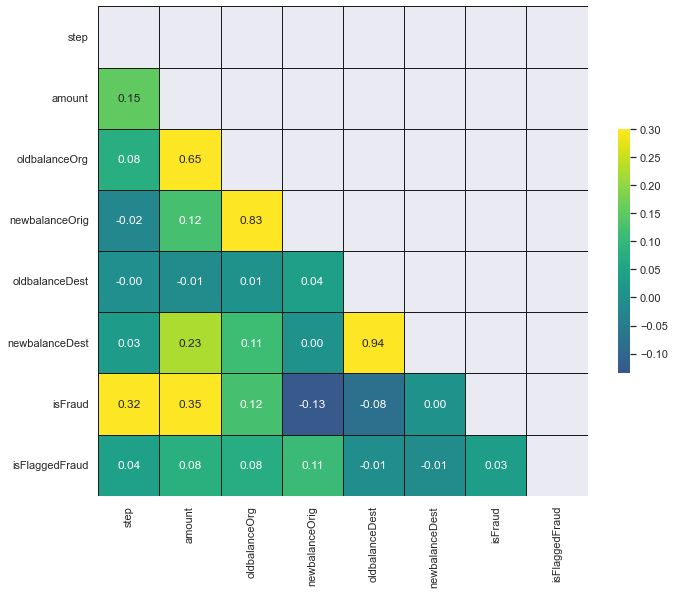

In [10]:
plt.figure(figsize=(20,18))

corr = df_reduced.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='viridis', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            linecolor='k', fmt='.2f', annot=True)
plt.show()

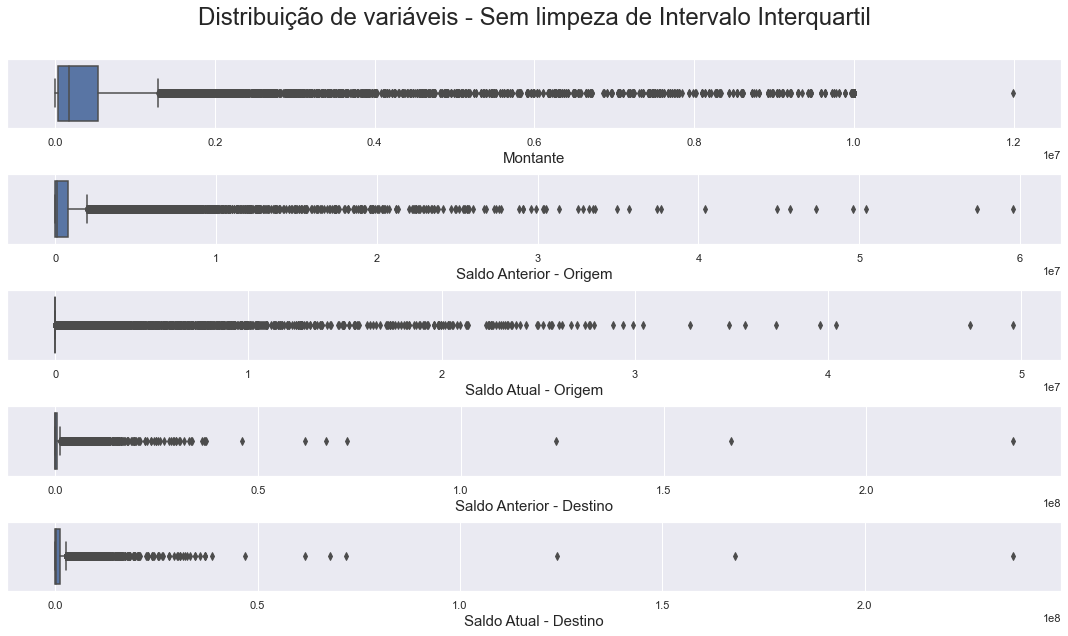

In [11]:
nome_colunas = {'amount': 'Montante',
                'oldbalanceOrg': 'Saldo Anterior - Origem',
                'newbalanceOrig': 'Saldo Atual - Origem',
                'oldbalanceDest': 'Saldo Anterior - Destino',
                'newbalanceDest': 'Saldo Atual - Destino',
                'step': 'Passo - Tempo',
                'isFraud': 'Fraude',
                'isFlaggedFraud': 'Flag de Fraude',
                }

fig = plt.figure(figsize= (15,9))

num_cols = list(df_reduced.select_dtypes(exclude=['object','int64']).columns)

for i, col in enumerate(num_cols):
    ax=fig.add_subplot(len(nome_colunas)-3,1,i+1)
    sns.boxplot(x=df_reduced[col], ax=ax)
    plt.xlabel(nome_colunas[col], fontdict={'fontsize': 15})
    fig.tight_layout()

fig.suptitle('Distribuição de variáveis - Sem limpeza de Intervalo Interquartil\n', size = 24)
plt.subplots_adjust(top=0.90)
plt.show()

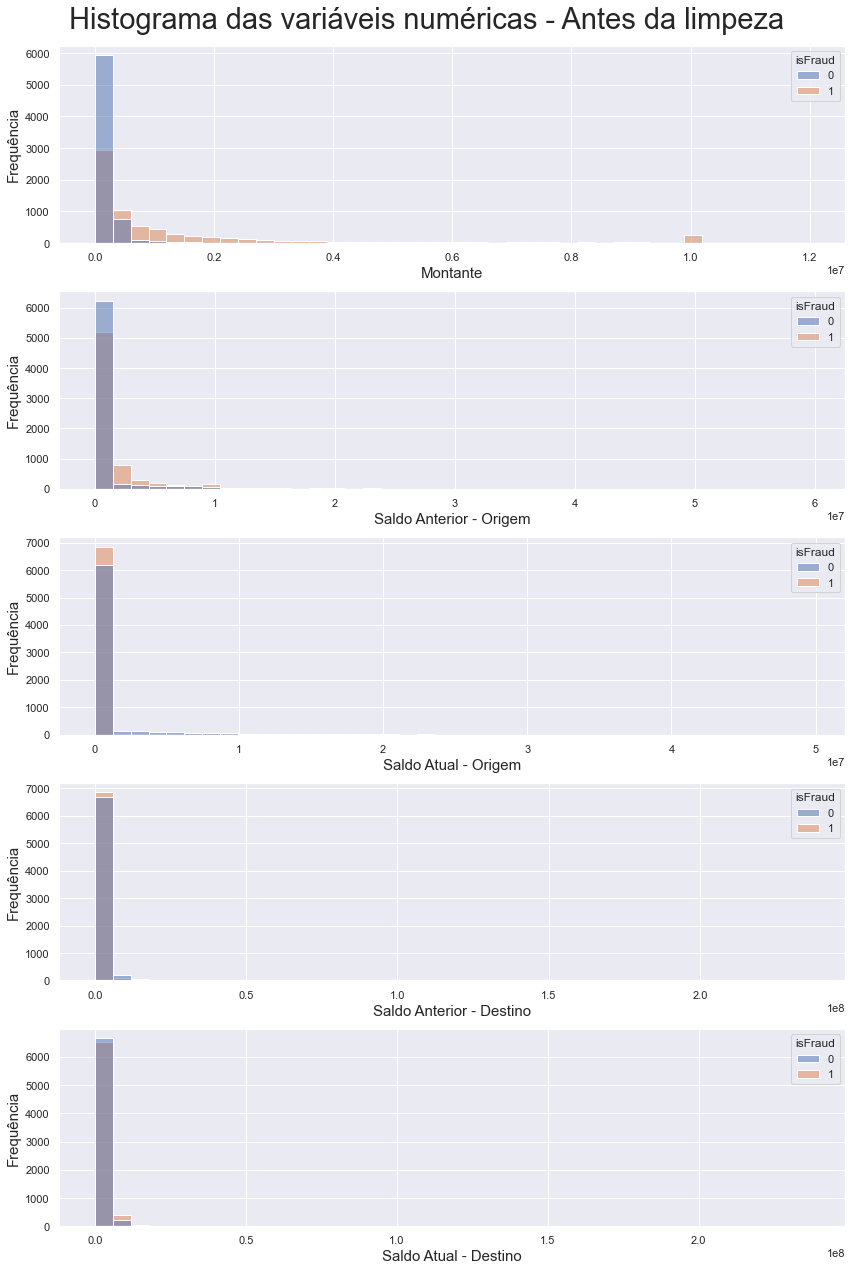

In [12]:
fig, axs = plt.subplots(len(nome_colunas)-3, 1, figsize = (12,18))

for i, col in enumerate(numericals):
    sns.histplot(data = df_reduced, x = col, hue = 'isFraud', ax = axs[i], bins=40)
    axs[i].set_xlabel(nome_colunas[col], fontdict={'fontsize': 15})
    axs[i].set_ylabel('Frequência', fontdict={'fontsize': 15})

fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Histograma das variáveis numéricas - Antes da limpeza', fontsize=29);

In [13]:
# from bokeh.plotting import figure, output_notebook, show, output_file
# from bokeh.models import ColumnDataSource

# p = figure(plot_width = 300, plot_height = 300, tools = "pan,reset,save")
# source = ColumnDataSource(data = dict(x = sample1.amount, y = sample1.index))

# p.circle(x='x', y = 'y', source=source, color = 'navy', alpha = 0.5)

# output_notebook()
# show(p)

# Data Cleaning

In [14]:
# from dataprep.eda import plot

# plot(df_reduced)

In [15]:
df_clean = df_reduced.copy()

print('Número de linhas pré limpeza: ', df_reduced.shape[0])

# Limpando as colunas numéricas (fazendo somente limite superior pois muitos valores nulos - contas sem dinheiro)

for i in ['amount', 'oldbalanceOrg', 'oldbalanceDest', 'newbalanceDest']:
    
    q1, q3 = np.percentile(df_clean[i], [25, 75])
    
    iqr = q3 - q1
    lim_sup = q3 + 2 * iqr

    indice = df_clean[df_clean[i] >= lim_sup].index

    df_clean.drop(indice, inplace= True)

print('Número de linhas pós limpeza: ', df_clean.shape[0])

Número de linhas pré limpeza:  13962
Número de linhas pós limpeza:  9069


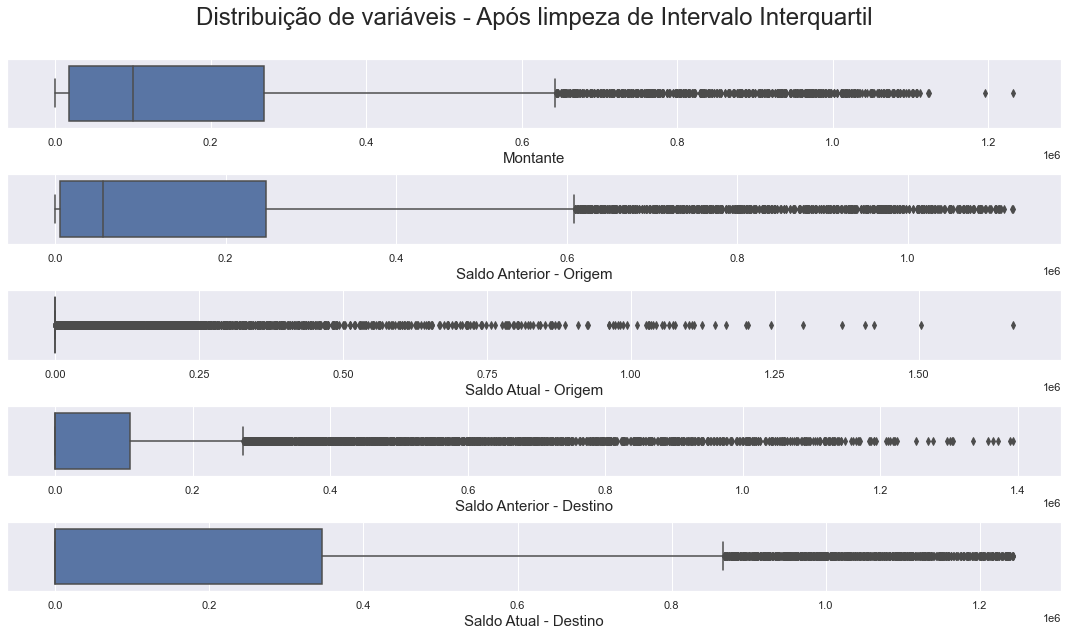

In [16]:
fig = plt.figure(figsize= (15,9))

for i, col in enumerate(num_cols):
    ax=fig.add_subplot(len(nome_colunas)-3,1,i+1)      
    sns.boxplot(x = df_clean[col], ax=ax)
    plt.xlabel(nome_colunas[col], fontdict={'fontsize': 15})
    fig.tight_layout()

fig.suptitle('Distribuição de variáveis - Após limpeza de Intervalo Interquartil\n', size = 24)
plt.subplots_adjust(top=0.90)
plt.show()

#### ***Atenção:** Escala diminuiu uma ordem de grandeza nas 3 variáveis, assim como saldo na origem mudou de espectro completamente (agora comporta valores negativos).

# >>> Seleção de Features <<<

# >>>  Modelagem  <<<

In [17]:
#Imports de Modelagem (Normalização, Splits, Modelos, Validação)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Pré-processamento

In [18]:
#Normalização das variáveis numéricas

df_clean[numericals] = StandardScaler().fit_transform(df_clean[numericals])

# Codificação da coluna 'Type'ArithmeticError

codec = pd.DataFrame(df_reduced['type'].factorize()[1], columns = ['type'])
print('*Codificação da variável categórica "type":  \n\n', codec)

df_clean['type'] = df_clean['type'].factorize()[0]

*Codificação da variável categórica "type":  

        type
0  TRANSFER
1  CASH_OUT
2   PAYMENT
3   CASH_IN
4     DEBIT


In [19]:
#Definição de Features e Target

features = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

X = df_clean[features]
y = df_clean['isFraud']

#Splits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

### Testando Modelos com cross_val_score

In [20]:
# Criando comparação de acurácia entre os 7 modelos escolhidos

comparacao_modelos = pd.DataFrame(columns = ['Modelo', 'Score'])

modelos = [LogisticRegression('l2', solver='lbfgs', random_state=42),
           KNeighborsClassifier(n_neighbors = 41, p = 4),
           ExtraTreesClassifier(random_state = 42),
           IsolationForest(n_jobs = -1, random_state = 42),
           XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
           StackingClassifier(estimators=[('xgbc', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)),
                                          ('log_reg', LogisticRegression(n_jobs = -1, random_state=42))
                                          ],
                              final_estimator=LogisticRegression('l2', solver='lbfgs', random_state=42)
                              )
           ]

for model in modelos:
    model_name = model.__class__.__name__
    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'accuracy')
    comparacao_modelos.loc[len(comparacao_modelos)] = [model_name, scores.mean().round(4)]

comparacao_modelos = comparacao_modelos.sort_values(by='Score', ascending=False)

print('* Comparação Cross-Validation Score entre modelos: ')
comparacao_modelos

c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages

* Comparação Cross-Validation Score entre modelos: 


,Modelo,Score
4,XGBClassifier,0.9913
5,StackingClassifier,0.9912
2,ExtraTreesClassifier,0.9844
0,LogisticRegression,0.9759
1,KNeighborsClassifier,0.9453
3,IsolationForest,0.3814


### * Modelo Baseline: Dummy Classifier

In [21]:
dummymodel = DummyClassifier(strategy='prior')
dummymodel.fit(X_train, y_train)

y_pred_dummy = dummymodel.predict(X_test)

Acurácia:  0.5311


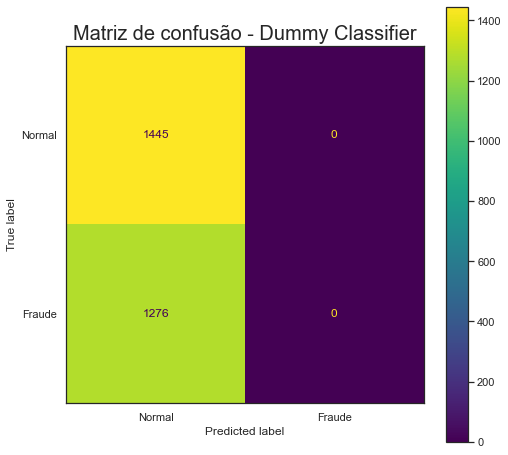

In [22]:
print('Acurácia: ', accuracy_score(y_test, y_pred_dummy).round(4))

sns.set_theme(style='white')
cmd1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dummy), display_labels=['Normal', 'Fraude'])
fig, ax = plt.subplots(figsize=(8,8))
plt.grid(False)
cmd1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Dummy Classifier', fontsize = 20)
plt.show()

### * 1º Modelo: Extra Trees Classifier

In [23]:
#Fazer BayesSearchCV para ExtraTrees
xtc = ExtraTreesClassifier(warm_start = True, n_jobs = -1, random_state=42)

In [24]:
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

xtc_param_dict = {'n_estimators': Integer(2, 800),
                  'criterion': Categorical(['gini', 'entropy']),
                  'max_depth': Integer(1, 15)
                  }

bayessearch_xtc = BayesSearchCV(xtc,
                                search_spaces = xtc_param_dict,
                                scoring = 'f1',
                                cv = 3,
                                refit = 'recall',
                                verbose = 1,
                                n_jobs = -1,
                                random_state = 42
                                ).fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits



Melhores Parâmetros:  OrderedDict([('criterion', 'gini'), ('max_depth', 15), ('n_estimators', 583)]) 
 Melhor Score:  0.9801387890141635 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1445
           1       0.98      0.99      0.98      1276

    accuracy                           0.98      2721
   macro avg       0.98      0.98      0.98      2721
weighted avg       0.98      0.98      0.98      2721



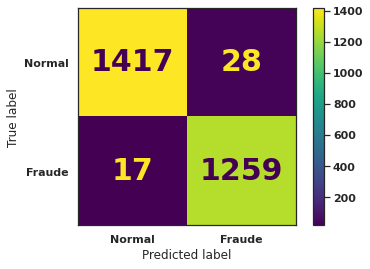

In [25]:
print('\nMelhores Parâmetros: ', bayessearch_xtc.best_params_, '\n Melhor Score: ', bayessearch_xtc.best_score_, '\n', classification_report(y_test, bayessearch_xtc.predict(X_test)))
xtc_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, bayessearch_xtc.predict(X_test)), display_labels=['Normal', 'Fraude']).plot()

#### Feature Importance (a título de curiosidade)

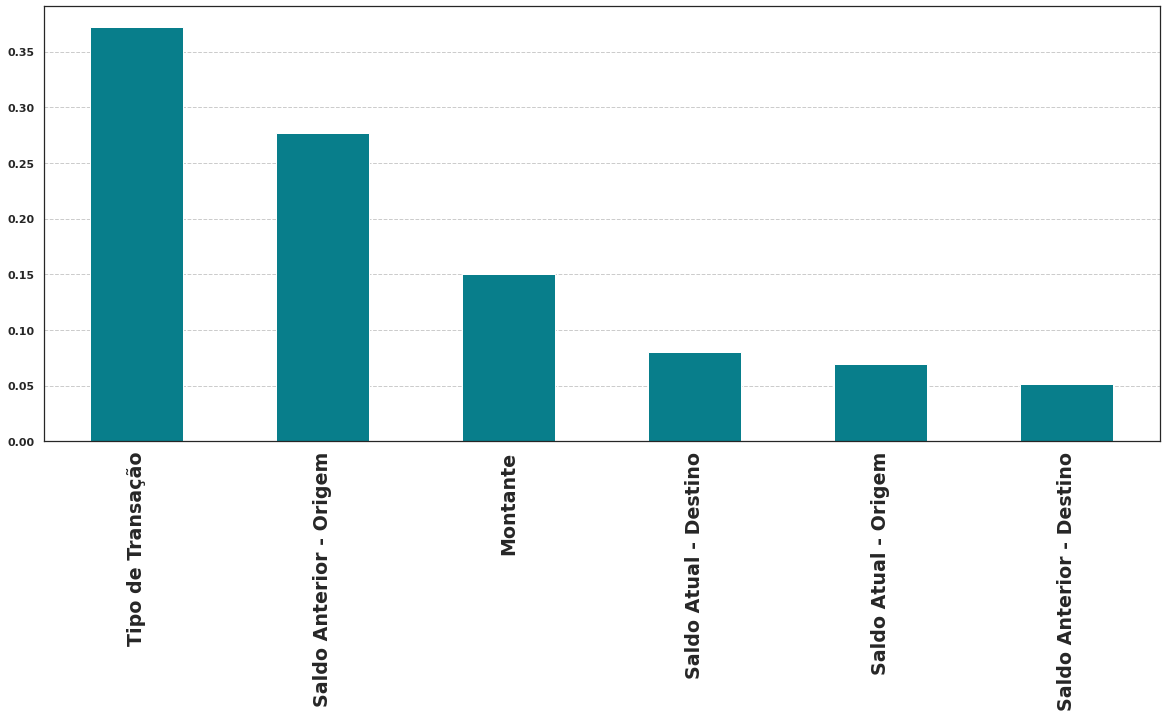

In [26]:
feats_ptbr = ['Tipo de Transação', 'Montante', 'Saldo Anterior - Origem', 'Saldo Atual - Origem', 'Saldo Anterior - Destino', 'Saldo Atual - Destino']

feat_importance = pd.Series(xtc.fit(X_train, y_train).feature_importances_, index=feats_ptbr).sort_values(ascending=False)

plt.figure(figsize = (20,8))
feat_importance.plot(kind = 'bar', color = '#087E8B')
plt.grid(which='major', axis='y', linestyle='--')
plt.xticks(fontsize = 19);

### * 2º Modelo: XGBoost Classifier

In [27]:
#Fazer BayesSearchCV para XGBoost
xgbc = XGBClassifier(eval_metric = 'logloss', use_label_encoder = False, n_jobs = -1)

In [28]:
xgbc_param_dict = {'learning_rate': Real(0.01, 0.99),
                   'max_depth': Integer(3,8),
                   'max_leaves': Integer(10, 100),
                  'n_estimators': Integer(1, 1000)
                   }

bayessearch_xgbc = BayesSearchCV(xgbc,
                                 search_spaces = xgbc_param_dict,
                                 scoring = 'recall',
                                 cv = 3,
                                 refit = 'recall',
                                 verbose = 1,
                                 n_jobs = -1,
                                 random_state = 42
                                 ).fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Melhores Parâmetros:  OrderedDict([('learning_rate', 0.013060668880768216), ('max_depth', 7), ('max_leaves', 94), ('n_estimators', 994)]) 
 Melhor Score:  0.9973118279569891 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1445
           1       0.99      0.99      0.99      1276

    accuracy                           0.99      2721
   macro avg       0.99      0.99      0.99      2721
weighted avg       0.99      0.99      0.99      2721



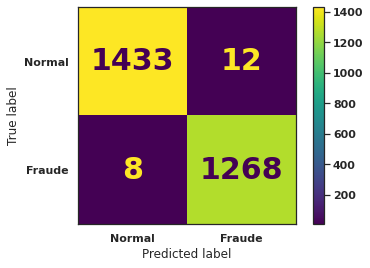

In [29]:
print('\nMelhores Parâmetros: ', bayessearch_xgbc.best_params_, '\n Melhor Score: ', bayessearch_xgbc.best_score_, '\n', classification_report(y_test, bayessearch_xgbc.predict(X_test)))
xgbc_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, bayessearch_xgbc.predict(X_test)), display_labels=['Normal', 'Fraude']).plot()

### * 3º Modelo: Isolation Forest Classifier

In [30]:
# Isolation Forest

ifc = IsolationForest(n_estimators = 7,
                      max_samples = 0.75,
                      contamination = 0.5,
                      max_features = 1,
                      n_jobs = -1,
                      warm_start = True,
                      random_state = 42
                      ).fit(X_train.values)

In [31]:
numpy_map = np.vectorize(lambda x: 1 if x==-1 else 0)

ifc_y_pred = numpy_map(ifc.predict(X_test.values))

              precision    recall  f1-score   support

           0       0.55      0.51      0.53      1445
           1       0.48      0.52      0.50      1276

    accuracy                           0.51      2721
   macro avg       0.51      0.51      0.51      2721
weighted avg       0.52      0.51      0.51      2721



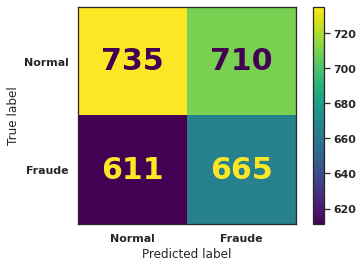

In [32]:
print(classification_report(y_test, ifc_y_pred))
ifc_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, ifc_y_pred), display_labels=['Normal', 'Fraude']).plot()

### Tentativa de fazer Isolation Forest funcionar como preditor padrão

In [33]:
# ifc_param_dict = {'n_estimators': Integer(2, 1000),
#                   'bootstrap': Categorical([True, False]),
#                   'max_features': Integer(1, 6)
#                   }

# bayessearch_ifc = BayesSearchCV(ifc,
#                                 search_spaces = ifc_param_dict,
#                                 scoring = 'recall',
#                                 cv = 3,
#                                 refit = 'recall',
#                                 verbose = 1,
#                                 n_jobs = -1,
#                                 random_state = 42
#                                 ).fit(X_train, y_train)

In [34]:
# df_ifc = fraud_df.copy()

# df_ifc = df_ifc.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

# df_ifc[numericals] = StandardScaler().fit_transform(df_ifc[numericals])
# df_ifc['type'] = df_ifc['type'].factorize()[0]

# X_train_ifc, X_test_ifc, y_train_ifc, y_test_ifc = train_test_split(df_ifc.drop('isFraud', axis=1), df_ifc['isFraud'], test_size=0.3, stratify=df_ifc['isFraud'], random_state=42)

In [35]:
# # Isolation Forest

# ifc_unbalance = IsolationForest(n_estimators = 100,
#                                 max_samples = 0.4,
#                                 contamination = df_ifc['isFraud'].value_counts(normalize=True)[1]*10,
#                                 max_features = 1,
#                                 n_jobs = -1,
#                                 random_state = 42
#                                 ).fit(X_train_ifc.values)

In [36]:
# numpy_map = np.vectorize(lambda x: 1 if x == -1 else 0)

# ifc_y_pred_unbalance = numpy_map(ifc.predict(X_test_ifc.values))

In [37]:
# print(df_ifc['isFraud'].value_counts(normalize=True)[1])

# print(pd.DataFrame(ifc.predict(X_test_ifc.values)).value_counts(normalize=True))

In [38]:
# print(classification_report(y_test_ifc, ifc_y_pred_unbalance))
# ifc_cm = ConfusionMatrixDisplay(confusion_matrix(y_test_ifc, ifc_y_pred_unbalance), display_labels=['Normal', 'Fraude']).plot()

Resultados muito ruins - mesmo utilizando de todos os 6.5M de dados para treino/teste, fazendo gambiarras para usar otimização bayesiana e como preditor comum, e ainda assim - , modelo pior que o mero chute! Não vale e pena seguir com esse modelo para o Stacking Ensemble. Utilizaremos a Regresão Logística, já que se trata de modelo com relação custo (computacional)-benefício (resultados, métricas etc) das mais altas na classificação, fora ainda a interpretabilidade e simplicidade de explicação.

### * 4º Modelo: Regressão Logística

In [39]:
log_reg = LogisticRegression(n_jobs = -1, random_state = 42)

In [97]:
logreg_param_dict = {'penalty': Categorical(['l2', 'none']),
                     'C': Real(0.01, 0.99),
                     'class_weight': Categorical(['balanced', None]),
                     'solver': Categorical(['newton-cg', 'lbfgs', 'sag', 'saga'])
                     }

bayessearch_logreg = BayesSearchCV(log_reg,
                                   search_spaces = logreg_param_dict,
                                   scoring = 'recall',
                                   cv = 3,
                                   refit = 'recall',
                                   verbose = 1,
                                   n_jobs = -1,
                                   random_state = 42
                                   ).fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



Melhores Parâmetros:  OrderedDict([('C', 0.4119018796762476), ('class_weight', None), ('penalty', 'none'), ('solver', 'newton-cg')]) 
 Melhor Score:  0.9959677419354839 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1445
           1       0.96      0.99      0.98      1276

    accuracy                           0.98      2721
   macro avg       0.98      0.98      0.98      2721
weighted avg       0.98      0.98      0.98      2721



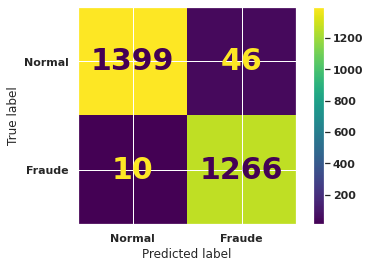

In [98]:
print('\nMelhores Parâmetros: ', bayessearch_logreg.best_params_, '\n Melhor Score: ', bayessearch_logreg.best_score_, '\n', classification_report(y_test, bayessearch_logreg.predict(X_test)))
logreg_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, bayessearch_logreg.predict(X_test)), display_labels=['Normal', 'Fraude']).plot()

### * 5º Modelo: Stacking Classifier

In [130]:
# StackingClassifier

# logreg_param_dict = {'penalty': Categorical(['l2', 'none']),
#                      'C': Real(0.01, 0.99),
#                      'class_weight': Categorical(['balanced', None]),
#                      'solver': Categorical(['newton-cg', 'lbfgs', 'sag', 'saga'])
#                      }

stack = StackingClassifier(estimators = [('xgbc', bayessearch_xgbc.best_estimator_),
                                         ('log_reg', bayessearch_logreg.best_estimator_)
                                         ],
                           final_estimator = LogisticRegression(solver = 'lbfgs', class_weight='balanced', random_state = 41, n_jobs = -1, max_iter = 100),
                           n_jobs = -1,
                           passthrough = True
                           ).fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1445
           1       0.99      0.99      0.99      1276

    accuracy                           0.99      2721
   macro avg       0.99      0.99      0.99      2721
weighted avg       0.99      0.99      0.99      2721



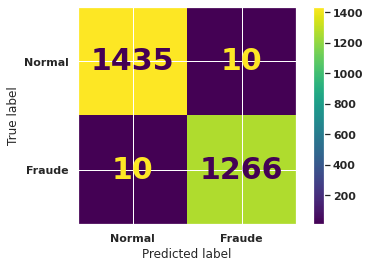

In [131]:
print(classification_report(y_test, stack.predict(X_test)))
stack_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, stack.predict(X_test)), display_labels=['Normal', 'Fraude']).plot()

## Comparativo Final dos Modelos

### Tabela de Métricas

In [132]:
comparativo_final_metricas = pd.DataFrame(columns = ['Acurácia', 'Recall', 'FN', 'F1-Score', 'AUROC'])

y_pred_dummy = dummymodel.predict(X_test)
y_pred_xt = bayessearch_xtc.predict(X_test)
y_pred_xgbc = bayessearch_xgbc.predict(X_test)
y_pred_logreg = bayessearch_logreg.predict(X_test)
y_pred_stack = stack.predict(X_test)

comparativo_final_metricas.loc['Dummy'] = [accuracy_score(y_test, y_pred_dummy).round(4),
                                           recall_score(y_test, y_pred_dummy, average='macro').round(4),
                                           confusion_matrix(y_test, y_pred_dummy)[1][0],
                                           f1_score(y_test, y_pred_dummy, average='macro').round(4),
                                           roc_auc_score(y_test, y_pred_dummy).round(4)
                                           ]

comparativo_final_metricas.loc['Extra Trees'] = [accuracy_score(y_test, y_pred_xt).round(4),
                                                 recall_score(y_test, y_pred_xt, average='macro').round(4),
                                                 confusion_matrix(y_test, y_pred_xt)[1][0],
                                                 f1_score(y_test, y_pred_xt, average='macro').round(4),
                                                 roc_auc_score(y_test, y_pred_xt).round(4)
                                                 ]

comparativo_final_metricas.loc['XGBoost'] = [accuracy_score(y_test, y_pred_xgbc).round(4),
                                             recall_score(y_test, y_pred_xgbc, average='macro').round(4),
                                             confusion_matrix(y_test, y_pred_xgbc)[1][0],
                                             f1_score(y_test, y_pred_xgbc, average='macro').round(4),
                                             roc_auc_score(y_test, y_pred_xgbc).round(4)
                                             ]

comparativo_final_metricas.loc['Logistic Regression'] = [accuracy_score(y_test, y_pred_logreg).round(4),
                                                      recall_score(y_test, y_pred_logreg, average='macro').round(4),
                                                      confusion_matrix(y_test, y_pred_logreg)[1][0],
                                                      f1_score(y_test, y_pred_logreg, average='macro').round(4),
                                                      roc_auc_score(y_test, y_pred_logreg).round(4)
                                                      ]

comparativo_final_metricas.loc['Stacking'] = [accuracy_score(y_test, y_pred_stack).round(4),
                                              recall_score(y_test, y_pred_stack, average='macro').round(4),
                                              confusion_matrix(y_test, y_pred_stack)[1][0],
                                              f1_score(y_test, y_pred_stack, average='macro').round(4),
                                              roc_auc_score(y_test, y_pred_stack).round(4)
                                              ]

In [133]:
comparativo_final_metricas = comparativo_final_metricas.sort_values(by='Recall', ascending=False)
comparativo_final_metricas

,Acurácia,Recall,FN,F1-Score,AUROC
XGBoost,0.9926,0.9927,8.0,0.9926,0.9927
Stacking,0.9926,0.9926,10.0,0.9926,0.9926
Extra Trees,0.9835,0.9836,17.0,0.9834,0.9836
Logistic Regression,0.9794,0.9802,10.0,0.9794,0.9802
Dummy,0.5311,0.5000,1276.0,0.3469,0.5000


### Curvas ROC

In [134]:
d_auc = roc_auc_score(y_test, dummymodel.predict(X_test)) #Dummy AUC
p_auc = roc_auc_score(y_test, y_test) #Perfection AUC
xtc_auc = roc_auc_score(y_test, bayessearch_xtc.predict(X_test)) #ExtraTrees AUC
xgb_auc = roc_auc_score(y_test, bayessearch_xgbc.predict(X_test)) #XGBoost AUC
ifc_auc = roc_auc_score(y_test, bayessearch_logreg.predict(X_test)) #Isolation Forest AUC
stack_auc = roc_auc_score(y_test, stack.predict(X_test)) #Stacking AUC

d_fpr, d_tpr, _ = roc_curve(y_test, dummymodel.predict(X_test)) #Dummy
p_fpr, p_tpr, _ = roc_curve(y_test, y_test) #Perfection
xtc_fpr, xtc_tpr, _ = roc_curve(y_test, bayessearch_xtc.predict(X_test)) #ExtraTrees
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, bayessearch_xgbc.predict(X_test)) #XGBoost
ifc_fpr, ifc_tpr, _ = roc_curve(y_test, bayessearch_logreg.predict(X_test)) #Isolation Forest
stack_fpr, stack_tpr, _ = roc_curve(y_test, stack.predict(X_test)) #Stacking

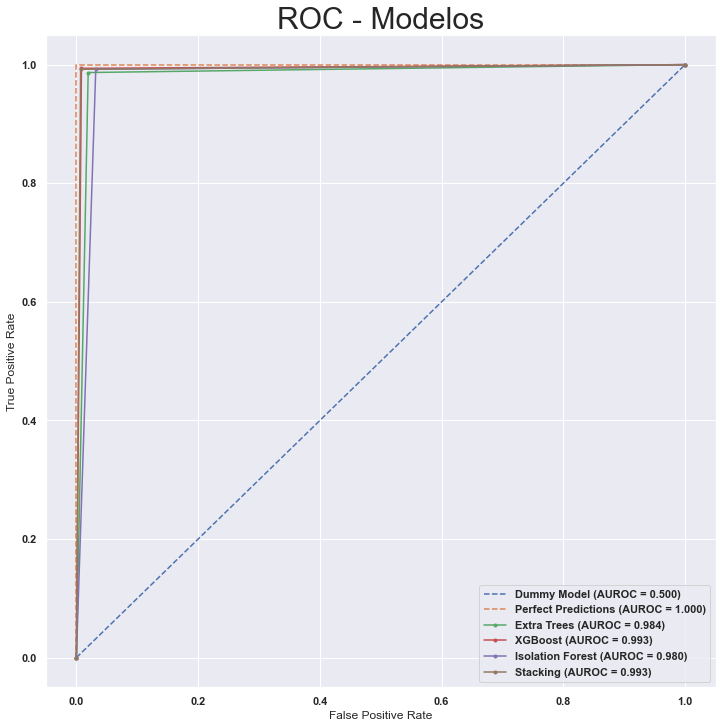

In [135]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 12))

plt.plot(d_fpr, d_tpr, linestyle='--', label='Dummy Model (AUROC = %0.3f)' % d_auc)
plt.plot(p_fpr, p_tpr, linestyle='--', label='Perfect Predictions (AUROC = %0.3f)' % p_auc)
plt.plot(xtc_fpr, xtc_tpr, marker='.', label='Extra Trees (AUROC = %0.3f)' % xtc_auc)
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost (AUROC = %0.3f)' % xgb_auc)
plt.plot(ifc_fpr, ifc_tpr, marker='.', label='Isolation Forest (AUROC = %0.3f)' % ifc_auc)
plt.plot(stack_fpr, stack_tpr, marker='.', label='Stacking (AUROC = %0.3f)' % stack_auc)

# Title
plt.title('ROC - Modelos', fontsize = 30)

# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show Grid
# plt.grid(which='both')

# Show legend
plt.legend()

# Show plot
plt.show()

## Pickle e Simulação de Deploy

In [143]:
# Criando dataset de deploy (cópia do dataset completo, com as transformações idênticas às de treino)

df_all = fraud_df.copy()
df_all = df_all.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

df_all = df_all.drop(df_clean.index, axis=0)

df_all[numericals] = StandardScaler().fit_transform(df_all[numericals])
df_all['type'] = df_all['type'].factorize()[0]

X_all = df_all.drop('isFraud', axis=1)
y_all = df_all['isFraud']

Aproveitando que utilizamos apenas parte dos dados nos treinamentos (graças ao undersampling), podemos utilizar os dados que não foram vistos pelos modelos e simular o *deploy* do melhor modelo em dados 'novos', assim testando a capacidade de generalização do preditor.

Portanto, primeiro vamos criar uma linearização exportável do modelo. Assim, numa situação comercial, teríamos um arquivo pronto para utilizar em servidor e/ou serviço de computação na nuvem.

* #### A título de exemplo e para análise comparativa, primeiro vamos fazer o deploy somente com o melhor modelo de Regressão Logística (**SEM** o Stacking):

In [144]:
# Serializando o melhor modelo de Regressão Logística	

import pickle

pickle.dump(bayessearch_logreg.best_estimator_, open('modelo_logreg.pkl', 'wb'))

A seguinte célula representa tudo o que o servidor teria que realizar com dados novos para realizar as predições em campo.

In [145]:
# Carregando modelo e fazendo predições

pickle_model_logreg = pickle.load(open('modelo_logreg.pkl', 'rb'))

y_pred_deploy_logreg = pickle_model_logreg.predict(X_all)

              precision    recall  f1-score   support

           0       1.00      0.65      0.79   6349590
           1       0.00      0.00      0.00      3961

    accuracy                           0.65   6353551
   macro avg       0.50      0.33      0.40   6353551
weighted avg       1.00      0.65      0.79   6353551



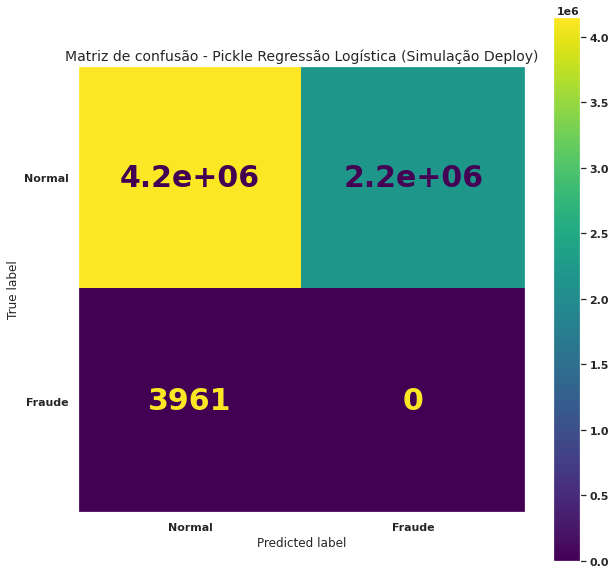

In [146]:
print(classification_report(y_all, y_pred_deploy_logreg))
cmp2 = ConfusionMatrixDisplay(confusion_matrix(y_all, y_pred_deploy_logreg), display_labels = ['Normal', 'Fraude'])
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp2.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Pickle Regressão Logística (Simulação Deploy)', fontsize = 14)
plt.show()

* ### Deploy com Stacking Classifier

In [147]:
# Serializando melhor modelo de Stacking (modelo final)

pickle.dump(stack, open('modelo_final.pkl', 'wb'))

A seguinte célula representa tudo o que o servidor teria que realizar com dados novos para realizar as predições em campo.

In [148]:
# Carregando modelo e fazendo predições

pickle_model = pickle.load(open('modelo_final.pkl', 'rb'))

y_pred_deploy = pickle_model.predict(X_all)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6349590
           1       0.15      0.03      0.05      3961

    accuracy                           1.00   6353551
   macro avg       0.57      0.52      0.53   6353551
weighted avg       1.00      1.00      1.00   6353551



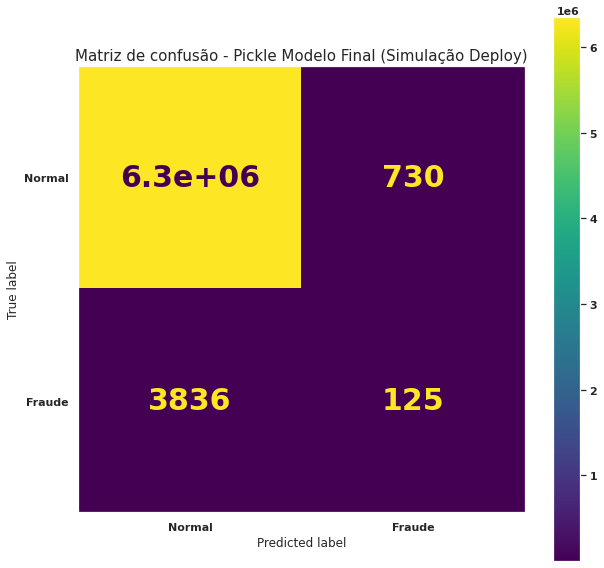

In [149]:
print(classification_report(y_all, y_pred_deploy))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_all, y_pred_deploy), display_labels = ['Normal', 'Fraude'])
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Pickle Modelo Final (Simulação Deploy)', fontsize = 15)
plt.show()

## Fim